In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
import numpy as np
import random
from collections import OrderedDict
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm


#Recursive function to generate Hadamard matrices of order equal to powers of two

H = {}
H[1] = torch.tensor([[1.0]])

def Had(n):
    if(n not in H):
        Hnby2 = Had(n//2)
        Hn = torch.ones(n, n)
        for i in range(n//2):
            for j in range(n//2):
                Hn[i][j] = Hnby2[i][j]
                Hn[i+n//2][j] = Hnby2[i][j]
                Hn[i][j+n//2] = Hnby2[i][j]
                Hn[i+n//2][j+n//2] = -Hnby2[i][j]
        H[n] = Hn
        return Hn
    return H[n]

# Generating n boolean functions in k variables
def generate_data(k, n):
    two_pow_k = pow(2, k)
    # Input validation
    if(n<two_pow_k):
        print(f"Need 2^{k} inputs atleast for the model to converge. Give a bigger number for n")
        return []
    if(n>pow(2, two_pow_k)):
        print(f"n is greater than 2^2^{k}. Generating max possible functions - 2^2^{k}")
    if(two_pow_k<=16):
#         For generating data of sufficient LI inputs:
        while(True):
            perm = torch.randperm(pow(2, two_pow_k))[:n]
            data = [[0.0]*(two_pow_k-len(bin(num)[2:]))+[float(i) for i in bin(num)[2:]] for num in perm]
            if(np.linalg.matrix_rank(data)<two_pow_k):
                print(f'Rank ({np.linalg.matrix_rank(data)}) of data is not large enough. Generating again.')
            else:
                print(f'Data generated. Rank = {np.linalg.matrix_rank(data)}')
                break
    else:
        data = [[0.0 if random.random()>0.5 else 1.0 for i in range(two_pow_k)] for i in range(n)]
        print("Data generated.")
    return data

def walsh_spectrum(bool_functions):
    two_pow_k = len(bool_functions[0])
    proc_functions = torch.Tensor([[1.0 if el==0.0 else -1.0 for el in bool_fun] for bool_fun in bool_functions])
    ws = 0.5*(two_pow_k-abs(torch.matmul(proc_functions, Had(two_pow_k))))
    return ws

In [ ]:
# Please change the number of variables (k) in the Boolean function and 
# the number of functions to be given as input here
k = 4
two_pow_k = pow(2, k)
n = pow(2, two_pow_k)
numberOfInputs = 30000 # = pow(2, pow(2, k))

print("k, 2**k, n, no_inputs: ", k, two_pow_k, n, numberOfInputs)

4 16 65536


In [50]:
functions = torch.tensor(generate_data(k, numberOfInputs))
ws = walsh_spectrum(functions)
nls = torch.min(ws, dim=1).values.unsqueeze(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

inputs_train, inputs_temp, labels_train, labels_temp = train_test_split(functions.to(device), nls.to(device), test_size=0.2, random_state=42)
inputs_valid, inputs_test, labels_valid, labels_test = train_test_split(inputs_temp, labels_temp, test_size=0.5, random_state=42)

print("Training set size:", len(inputs_train))
print("Validation set size:", len(inputs_valid))
print("Test set size:", len(inputs_test))

Data generated. Rank = 16
tensor([[1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.],
        [0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.]])
tensor([[7., 7., 5., 3., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 5., 5.],
        [8., 8., 6., 6., 8., 4., 6., 6., 8., 8., 6., 6., 8., 4., 6., 6.],
        [6., 6., 6., 6., 4., 8., 8., 8., 6., 6., 6., 6., 4., 8., 8., 8.],
        [4., 8., 6., 6., 8., 8., 6., 6., 6., 6., 4., 8., 6., 6., 8., 8.]])
tensor([[3.],
        [4.],
        [4.],
        [4.]])


In [53]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            nn.init.kaiming_normal_(self.layers[-1].weight)

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = F.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x
    
no_nodes = [64//(2**i) for i in range(int(math.log(64, 2)))]
model = NeuralNetwork([32]+no_nodes+[1]).to(device)

In [55]:
# Define the loss function and optimizer

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=200, mode='triangular', cycle_momentum=False)

In [56]:
# Training loop
learningRate = 0.1
batchSize = 64
max_epochs = 100

patience = 10  # Number of epochs to wait for improvement before stopping
best_loss = np.inf  # Initialize best loss to infinity
epochs_no_improve = 0  # Counter to keep track of number of epochs without improvement
loss, validation_loss = np.inf, np.inf

# Create a TensorDataset and DataLoader from inputs and labels
dataset = TensorDataset(inputs_train, labels_train)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

for epoch in tqdm(range(max_epochs)):  # 100 epochs
    for batch_inputs, batch_labels in dataloader:  # Iterate over batches
        optimizer.zero_grad()  # Zero the gradients
        predictions = model(batch_inputs)  # Forward pass
        loss = loss_fn(predictions, batch_labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    if epoch % 2 == 0:  # Print loss every 2 epochs
        with torch.no_grad():  # Disable gradient computation for validation
            validation_predictions = model(inputs_valid)  # Get validation predictions
            validation_loss = loss_fn(validation_predictions, labels_valid)  # Compute validation loss
        print(f'Epoch {epoch}, Train loss: {loss.item()}, Validation loss: {validation_loss.item()}')

        # Check if the validation loss has improved
        if validation_loss.item() < 0.90*best_loss:
            best_loss = validation_loss.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 2
            # If the validation loss hasn't improved for 'patience' epochs, stop training
            if epochs_no_improve >= patience:
                print('Stopping early!')
                break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.6203956007957458, Validation loss: 1.0767154693603516
Epoch 2, Train loss: 1.0139473676681519, Validation loss: 0.8429515361785889
Epoch 4, Train loss: 0.5972608327865601, Validation loss: 0.8374539017677307
Epoch 6, Train loss: 0.8730847835540771, Validation loss: 0.8223941922187805
Epoch 8, Train loss: 0.72479248046875, Validation loss: 0.7996020913124084
Epoch 10, Train loss: 0.7639753222465515, Validation loss: 0.7867345213890076
Epoch 12, Train loss: 0.5157390236854553, Validation loss: 0.7699894905090332
Epoch 14, Train loss: 1.0534406900405884, Validation loss: 0.752424955368042
Epoch 16, Train loss: 0.6246572732925415, Validation loss: 0.724457859992981
Epoch 18, Train loss: 0.7014378309249878, Validation loss: 0.7182365655899048
Epoch 20, Train loss: 0.985036313533783, Validation loss: 0.6776837706565857
Epoch 22, Train loss: 0.661239743232727, Validation loss: 0.6190766096115112
Epoch 24, Train loss: 0.42891785502433777, Validation loss: 0.4678153395652

In [57]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use the model to make predictions on the test data
with torch.no_grad():
    y_pred = torch.round(model(inputs_test))
    y_pred_val = torch.round(model(inputs_valid))
    y_pred_train = torch.round(model(inputs_train))

# Convert the predictions and the labels to numpy arrays
y_test_np = labels_test.cpu().numpy()
y_valid_np = labels_valid.cpu().numpy()
y_train_np = labels_train.cpu().numpy()
y_pred_np = y_pred.detach().cpu().numpy()
y_pred_val_np = y_pred_val.detach().cpu().numpy()
y_pred_train_np = y_pred_train.detach().cpu().numpy()

In [58]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each split
train_accuracy = accuracy_score(y_train_np, y_pred_train_np)
valid_accuracy = accuracy_score(y_valid_np, y_pred_val_np)
test_accuracy = accuracy_score(y_test_np, y_pred_np)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {valid_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Train accuracy: 99.74%
Validation accuracy: 99.53%
Test accuracy: 99.59%


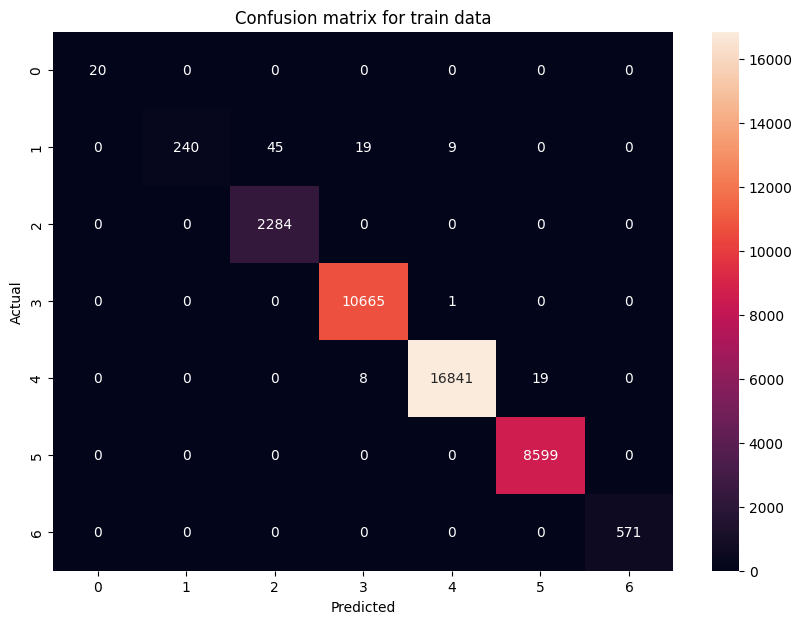

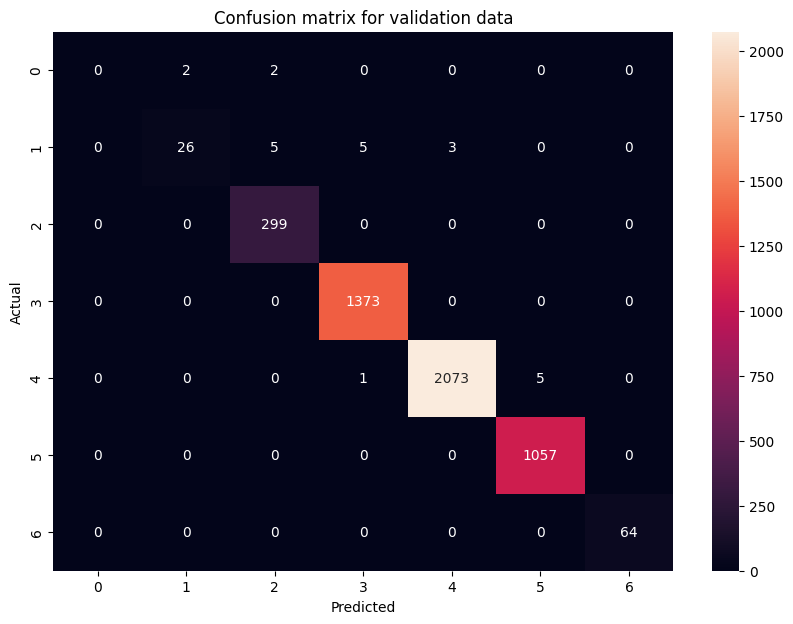

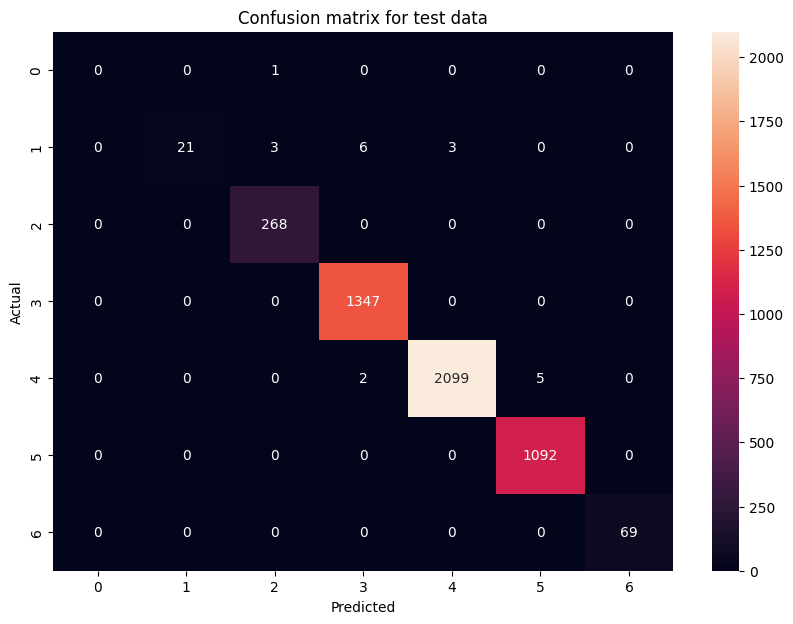

In [59]:
# Compute the confusion matrix
cm1 = confusion_matrix(y_test_np, y_pred_np)
cm2 = confusion_matrix(y_valid_np, y_pred_val_np)
cm3 = confusion_matrix(y_train_np, y_pred_train_np)

# Print the confusion matrix
# print(cm1)
# print(cm2)

# Plot confusion matrix for train data
plt.figure(figsize=(10, 7))
sns.heatmap(cm3, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for train data')
plt.show()

# Plot confusion matrix for validation data
plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for validation data')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(10, 7))
sns.heatmap(cm1, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for test data')
plt.show()


In [61]:
torch.save(model.state_dict(), 'n4_30k_samples_relu_model.pth')
